![banner](https://github.com/AndreaBernal00/Hands-on-Computer-Vision/blob/main/sesiones/sesion3/banner.png?raw=1)

## LoRAs of the World Unite - Let's do inference on our Diffusion Model fine-tuned using DreamBooth LoRA with Pivotal Tuning 🧨

This was achieved thanks to [🤗 Transformers Notebooks](https://huggingface.co/docs/transformers/en/notebooks) that showed how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) using some of the most popular SOTA methods. See the notebook [here](https://github.com/huggingface/notebooks/blob/main/diffusers/SDXL_Dreambooth_LoRA_advanced_example.ipynb).



## Inference 🐕

In [1]:
repo_id = 'SemilleroCV/sdxl-pinky' #@param

In [3]:
%%capture
import torch
from huggingface_hub import hf_hub_download, upload_file
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
from safetensors.torch import load_file

pipe = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
).to("cuda")

pipe.load_lora_weights(repo_id, weight_name="pytorch_lora_weights.safetensors")

#### Load Pivotal Tuning Embeddings

In [4]:
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = hf_hub_download(repo_id=repo_id, filename=f"pinky-lora_emb.safetensors", repo_type="model")

state_dict = load_file(embedding_path)
# load embeddings of text_encoder 1 (CLIP ViT-L/14)
pipe.load_textual_inversion(state_dict["clip_l"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer)
# load embeddings of text_encoder 2 (CLIP ViT-G/14)
pipe.load_textual_inversion(state_dict["clip_g"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder_2, tokenizer=pipe.tokenizer_2)

pinky-lora_emb.safetensors:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

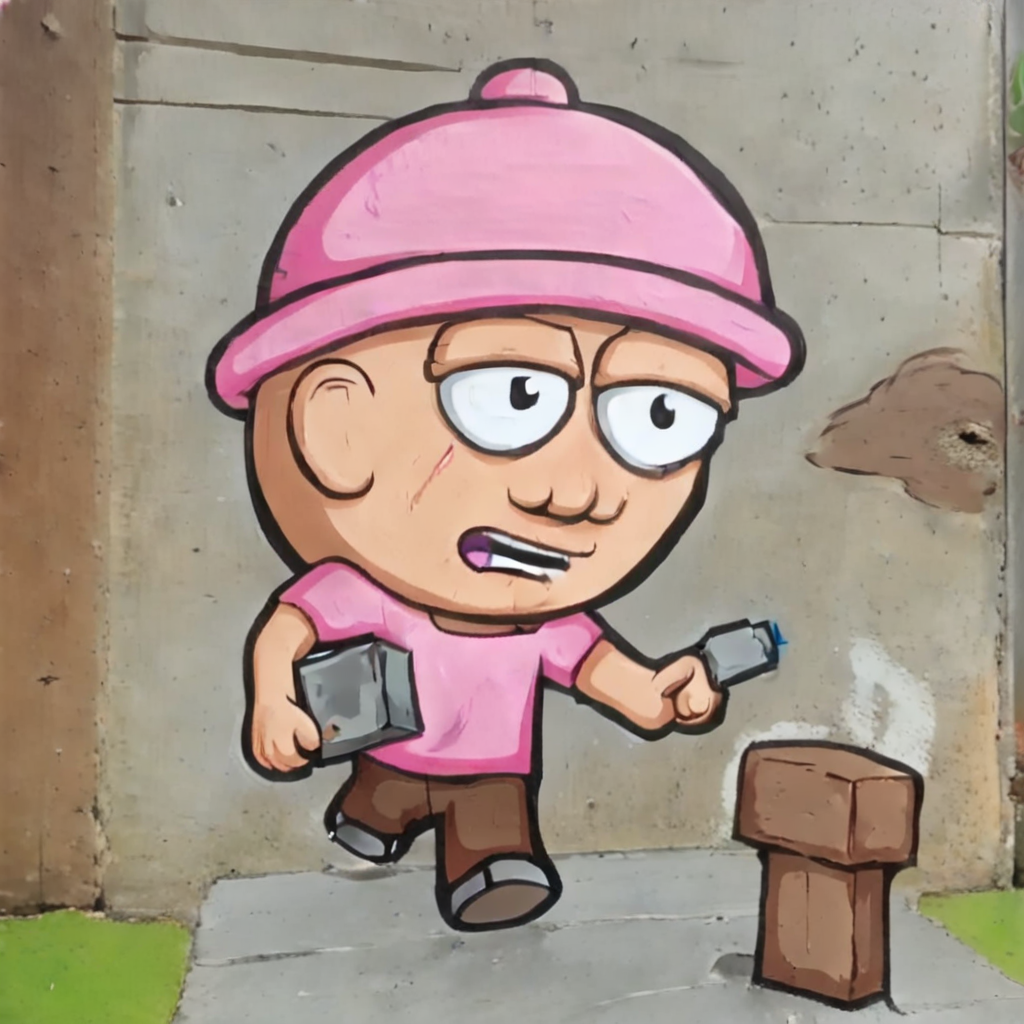

In [6]:
prompt = f"a cartoon character <s0><s1>, playing minecraft" #@param

image = pipe(prompt=prompt, num_inference_steps=25, cross_attention_kwargs={"scale": 1.0}).images[0]
image